# Part Two: Exploration of `northwind.sqlite` Database   

In this document we'll be exploring the performance of the nine employees listed in the `northwind.sqlite` database. We'll explore topics such as amount sold, products sold, performance over time, regional performance, strengths, and weaknesses. To get started, let's load the database and take a look at the tables provided.  

In [2]:
import sqlite3
import pandas as pd
import numpy as np

con = sqlite3.connect("northwind.sqlite")

In [4]:
pd.read_sql("SELECT * FROM sqlite_schema WHERE type = 'table' ORDER BY name", con)

,type,name,tbl_name,rootpage,sql
0,table,Categories,Categories,2,CREATE TABLE [Categories]\n( [CategoryID]...
1,table,CustomerCustomerDemo,CustomerCustomerDemo,28,CREATE TABLE [CustomerCustomerDemo](\n [Cust...
2,table,CustomerDemographics,CustomerDemographics,30,CREATE TABLE [CustomerDemographics](\n [Cust...
3,table,Customers,Customers,32,CREATE TABLE [Customers]\n( [CustomerID] ...
4,table,EmployeeTerritories,EmployeeTerritories,68,CREATE TABLE [EmployeeTerritories](\n [Emplo...
5,table,Employees,Employees,38,CREATE TABLE [Employees]\n( [EmployeeID] ...
6,table,Order Details,Order Details,70,CREATE TABLE [Order Details](\n [OrderID]INT...
7,table,Orders,Orders,92,CREATE TABLE [Orders](\n [OrderID]INTEGER NO...
8,table,Products,Products,128,CREATE TABLE [Products](\n [ProductID]INTEGE...
9,table,Regions,Regions,132,CREATE TABLE [Regions](\n [RegionID]INTEGER ...


## How Much Is Sold?  

## Which Products are Sold?  

The query below gathers data from the Order Details, Orders, Employees, Products, and Categories tables to explore the sales history of each employee.  

In [20]:
firstcall = '''
            SELECT d.OrderID, d.ProductID, p.ProductName, p.CategoryID, c.CategoryName, o.EmployeeID, e.FirstName, 
                   e.LastName, e.Title FROM 'Order Details' as d
                INNER JOIN Orders as o ON o.OrderID = d.OrderID
                INNER JOIN Employees as e ON e.EmployeeID = o.EmployeeID
                INNER JOIN Products as p ON p.ProductID = d.ProductID
                INNER JOIN Categories as c ON c.CategoryID = p.CategoryID
            '''
productsold = pd.read_sql(firstcall, con)
productsold

,OrderID,ProductID,ProductName,CategoryID,CategoryName,EmployeeID,FirstName,LastName,Title
0,10248,11,Queso Cabrales,4,Dairy Products,5,Steven,Buchanan,Sales Manager
1,10248,42,Singaporean Hokkien Fried Mee,5,Grains/Cereals,5,Steven,Buchanan,Sales Manager
2,10248,72,Mozzarella di Giovanni,4,Dairy Products,5,Steven,Buchanan,Sales Manager
3,10249,14,Tofu,7,Produce,6,Michael,Suyama,Sales Representative
4,10249,51,Manjimup Dried Apples,7,Produce,6,Michael,Suyama,Sales Representative
...,...,...,...,...,...,...,...,...,...
2150,11077,64,Wimmers gute SemmelknÃ¶del,5,Grains/Cereals,1,Nancy,Davolio,Sales Representative
2151,11077,66,Louisiana Hot Spiced Okra,2,Condiments,1,Nancy,Davolio,Sales Representative
2152,11077,73,RÃ¶d Kaviar,8,Seafood,1,Nancy,Davolio,Sales Representative
2153,11077,75,RhÃ¶nbrÃ¤u Klosterbier,1,Beverages,1,Nancy,Davolio,Sales Representative


First, we'll find each employee's most popular product. Note that this is computed using how frequently the product is ordered, not the quantity ordered.  

In [40]:
from collections import Counter

def most_common_item(List):
    Occurence_count = Counter(List)
    return Occurence_count.most_common(1)[0][0]


In [67]:
buchanan = productsold[productsold['LastName'] == 'Buchanan']
buc = most_common_item(buchanan.ProductName)

callahan = productsold[productsold['LastName'] == 'Callahan']
cal = most_common_item(callahan.ProductName)

davolio = productsold[productsold['LastName'] == 'Davolio']
dav = most_common_item(davolio.ProductName)

dodsworth = productsold[productsold['LastName'] == 'Dodsworth']
dod = most_common_item(dodsworth.ProductName)

fuller = productsold[productsold['LastName'] == 'Fuller']
ful = most_common_item(fuller.ProductName)

king = productsold[productsold['LastName'] == 'King']
kin = most_common_item(king.ProductName)

leverling = productsold[productsold['LastName'] == 'Leverling']
lev = most_common_item(leverling.ProductName)

peacock = productsold[productsold['LastName'] == 'Peacock']
pea = most_common_item(peacock.ProductName)

suyama = productsold[productsold['LastName'] == 'Suyama']
suy = most_common_item(suyama.ProductName)

keys = list(productsold.LastName.unique())
values = [buc, suy, pea, lev, dod, dav, cal, ful, kin]
comprod = pd.DataFrame(zip(keys,values), columns = ["Employee", "Most Common Product Sold"])
comprod

,Employee,Most Common Product Sold
0,Buchanan,Mozzarella di Giovanni
1,Suyama,Gorgonzola Telino
2,Peacock,Gnocchi di nonna Alice
3,Leverling,GumbÃ¤r GummibÃ¤rchen
4,Dodsworth,Raclette Courdavault
5,Davolio,Flotemysost
6,Callahan,Steeleye Stout
7,Fuller,Singaporean Hokkien Fried Mee
8,King,Sasquatch Ale


Next, we'll look at the distribution of orders over each product category across employees. Let's first create a table with this information:  

In [68]:
catbyemp = pd.crosstab(productsold.LastName, productsold.CategoryName)
catbyemp

CategoryName,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood
LastName,,,,,,,,
Buchanan,21,8,15,31,9,11,10,12
Callahan,51,30,42,34,26,24,16,37
Davolio,60,31,56,65,21,25,28,59
Dodsworth,24,15,13,25,3,6,2,19
Fuller,45,24,35,36,27,26,12,36
King,36,20,27,31,15,15,9,23
Leverling,63,28,52,51,37,21,15,54
Peacock,75,45,71,54,46,35,25,69
Suyama,29,15,23,39,12,10,19,21


Below we can visually represent the data from the table above using a bar plot. Some observations to note are that Peacock has the most sales overall, and their most frequently ordered products are from the Beverages category. The most popular categories for each employee are summarized in the table below:  

| Employee | Category |  
| -------- | -------- |  
| Buchanan | Dairy Products |  
| Callahan | Beverages |  
| Davolio | Dairy Products |  
| Dodsworth | Dairy Products |  
| Fuller | Beverages |  
| King | Beverages |  
| Leverling | Beverages |  
| Peackock | Beverages |  
| Suyama | Dairy Products |  

Text(0.5, 1.0, 'Frequency of Orders Across Product Categories for Each Employee')

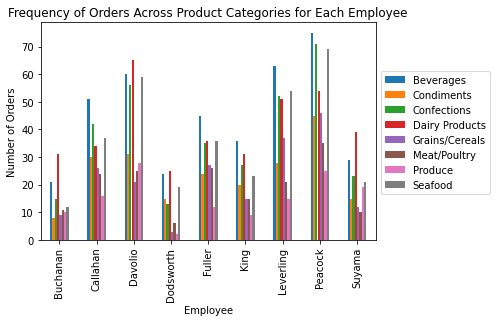

In [77]:
import matplotlib.pyplot as plt

catbyemp.plot.bar()
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.8))
plt.xlabel("Employee")
plt.ylabel("Number of Orders")
plt.title("Frequency of Orders Across Product Categories for Each Employee")

Clearly, the product categories with the most orders are Beverages and Dairy Products. The number of employees with either as their most popular category is almost split evenly.  

## Performance Across the Years  

Now we'll examine employee performance across the years. This is best examined by looking at total revenue from each employee during each year, so we'll pull data from the Order Details, Orders, and Employees tables.  

In [136]:
second_call = '''
              SELECT d.OrderID, d.UnitPrice, d.Quantity, d.Discount, o.EmployeeID, e.LastName, o.OrderDate 
                     FROM 'Order Details' as d
                  INNER JOIN Orders as o ON o.OrderId = d.OrderID
                  INNER JOIN Employees as e ON e.EmployeeID = o.EmployeeID
              '''

sales = pd.read_sql(second_call, con)
sales

,OrderID,UnitPrice,Quantity,Discount,EmployeeID,LastName,OrderDate
0,10248,14.00,12,0.00,5,Buchanan,1996-07-04 00:00:00.000
1,10248,9.80,10,0.00,5,Buchanan,1996-07-04 00:00:00.000
2,10248,34.80,5,0.00,5,Buchanan,1996-07-04 00:00:00.000
3,10249,18.60,9,0.00,6,Suyama,1996-07-05 00:00:00.000
4,10249,42.40,40,0.00,6,Suyama,1996-07-05 00:00:00.000
...,...,...,...,...,...,...,...
2150,11077,33.25,2,0.03,1,Davolio,1998-05-06 00:00:00.000
2151,11077,17.00,1,0.00,1,Davolio,1998-05-06 00:00:00.000
2152,11077,15.00,2,0.01,1,Davolio,1998-05-06 00:00:00.000
2153,11077,7.75,4,0.00,1,Davolio,1998-05-06 00:00:00.000


Now we need to create a couple of new variables to find the exact information we're looking for. First, we'll use the `OrderDate` variable and extract only the first four characters of the string to create an `OrderYear` variable. Then we'll define a function that uses `UnitPrice`, `Quantity`, and `Discount` to calculate the total revenue for each order. We'll call this variable `OrderRevenue`.  

In [137]:
sales['OrderYear'] = sales.OrderDate.str[:4]

def tot_rev(unitprice, quantity, discount):
    subtot = unitprice * quantity
    disc = subtot * discount
    tot = subtot - discount
    return tot

sales['OrderRevenue'] = tot_rev(sales.UnitPrice, sales.Quantity, sales.Discount)
sales

,OrderID,UnitPrice,Quantity,Discount,EmployeeID,LastName,OrderDate,OrderYear,OrderRevenue
0,10248,14.00,12,0.00,5,Buchanan,1996-07-04 00:00:00.000,1996,168.00
1,10248,9.80,10,0.00,5,Buchanan,1996-07-04 00:00:00.000,1996,98.00
2,10248,34.80,5,0.00,5,Buchanan,1996-07-04 00:00:00.000,1996,174.00
3,10249,18.60,9,0.00,6,Suyama,1996-07-05 00:00:00.000,1996,167.40
4,10249,42.40,40,0.00,6,Suyama,1996-07-05 00:00:00.000,1996,1696.00
...,...,...,...,...,...,...,...,...,...
2150,11077,33.25,2,0.03,1,Davolio,1998-05-06 00:00:00.000,1998,66.47
2151,11077,17.00,1,0.00,1,Davolio,1998-05-06 00:00:00.000,1998,17.00
2152,11077,15.00,2,0.01,1,Davolio,1998-05-06 00:00:00.000,1998,29.99
2153,11077,7.75,4,0.00,1,Davolio,1998-05-06 00:00:00.000,1998,31.00


In [142]:
timerev = pd.pivot_table(sales, values = ["OrderRevenue"], index = ["LastName", "OrderYear"], aggfunc = ["sum"])
timerev

sum
                    OrderRevenue
LastName  OrderYear             
Buchanan  1996          21963.00
          1997          32591.70
          1998          21005.25
Callahan  1996          23159.80
          1997          59767.22
          1998          50359.41
Davolio   1996          38784.35
          1997          97526.48
          1998          65815.89
Dodsworth 1996          11364.35
          1997          29573.50
          1998          42018.85
Fuller    1996          22832.75
          1997          74954.60
          1998          79951.36
King      1996          18103.05
          1997          66682.34
          1998          56497.65
Leverling 1996          19230.30
          1997         111781.01
          1998          82024.04
Peacock   1996          53110.25
          1997         139463.00
          1998          57588.45
Suyama    1996          17729.15
          1997          45986.10
          1998          14473.70

In [143]:
timerev.columns.name = None
timerev = timerev.reset_index()

In [145]:
timerev.columns = ["LastName", "OrderYear", "RevenueSum"]
timerev_new = timerev.pivot(index = "OrderYear", columns = ["LastName"], values = "RevenueSum")
timerev_new

LastName,Buchanan,Callahan,Davolio,Dodsworth,Fuller,King,Leverling,Peacock,Suyama
OrderYear,,,,,,,,,
1996,21963.00,23159.80,38784.35,11364.35,22832.75,18103.05,19230.30,53110.25,17729.15
1997,32591.70,59767.22,97526.48,29573.50,74954.60,66682.34,111781.01,139463.00,45986.10
1998,21005.25,50359.41,65815.89,42018.85,79951.36,56497.65,82024.04,57588.45,14473.70


Text(0.5, 1.0, 'Total Sales Revenue for Each Employee Across the Years')

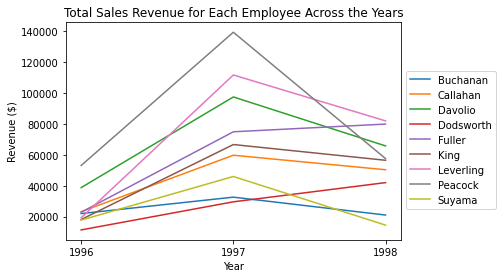

In [149]:
Year = ["1996", "1997", "1998"]

plt.plot(Year, timerev_new.Buchanan, label = "Buchanan")
plt.plot(Year, timerev_new.Callahan, label = "Callahan")
plt.plot(Year, timerev_new.Davolio, label = "Davolio")
plt.plot(Year, timerev_new.Dodsworth, label = "Dodsworth")
plt.plot(Year, timerev_new.Fuller, label = "Fuller")
plt.plot(Year, timerev_new.King, label = "King")
plt.plot(Year, timerev_new.Leverling, label = "Leverling")
plt.plot(Year, timerev_new.Peacock, label = "Peacock")
plt.plot(Year, timerev_new.Suyama, label = "Suyama")

plt.legend(bbox_to_anchor = (1, 0.8))
plt.xlabel("Year")
plt.ylabel("Revenue ($)")
plt.title("Total Sales Revenue for Each Employee Across the Years")

## Regional Performance  

## Strengths and Weaknesses of Each Employee  